In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [20]:
# Read the final results csv here
vae_classifier_results = pd.read_csv('./results/lfm2b_final_results_[\'country\']_0.5_0.5_0.5.csv')

In [21]:
def space_separated_str_to_list(space_separated_str):
    return [int(x) for x in space_separated_str.split()]


# Apply the function to each column
vae_classifier_results["missing_terms"] = vae_classifier_results["missing_terms"].apply(
    space_separated_str_to_list
)
vae_classifier_results["recommended_terms"] = vae_classifier_results[
    "recommended_terms"
].apply(space_separated_str_to_list)


# Custom function to calculate precision at different levels
def precision_at_k(recommended, missing, k):
    recommended_k = recommended[:k]
    found_terms = set(recommended_k) & set(missing)
    precision = len(found_terms) / k if k > 0 else 0
    return precision


def calculate_UFAIR_(df, attribute_columns, k_value):
    # Group by the specified columns
    grouped_df = df.groupby(attribute_columns)

    # Initialize a variable to store the result
    result = 0

    # Loop over groups
    for group1, data1 in grouped_df:
        for group2, data2 in grouped_df:
            group_1_final_res = 0
            group_2_final_res = 0
            # Calculate the precision@K sum for group 1
            count_users_group_1 = len(data1["user_id"].unique())
            prec_sum_group_1 = data1["PREC@{}".format(k_value)].sum()

            # Calculate the precision@K sum for group 2
            count_users_group_2 = len(data2["user_id"].unique())
            prec_sum_group_2 = data2["PREC@{}".format(k_value)].sum()

            # Calculate the result for the group and update the overall result
            if count_users_group_1 > 0:
                group_1_final_res = prec_sum_group_1 / count_users_group_1

            if count_users_group_2 > 0:
                group_2_final_res = prec_sum_group_2 / count_users_group_2

            result = result + abs(group_1_final_res - group_2_final_res)

    total_groups = len(grouped_df)
    return result / total_groups**2


# Apply the function to create new columns
vae_classifier_results["PREC@1"] = vae_classifier_results.apply(
    lambda row: precision_at_k(row["recommended_terms"], row["missing_terms"], 1),
    axis=1,
)
vae_classifier_results["PREC@10"] = vae_classifier_results.apply(
    lambda row: precision_at_k(row["recommended_terms"], row["missing_terms"], 10),
    axis=1,
)
vae_classifier_results["PREC@20"] = vae_classifier_results.apply(
    lambda row: precision_at_k(row["recommended_terms"], row["missing_terms"], 20),
    axis=1,
)

In [22]:
calculate_UFAIR_(vae_classifier_results,["country"],k_value=20)

0.03172728192019052

In [23]:
# Group by 'country' and calculate the mean for each group
grouped_df = vae_classifier_results.groupby('country')[['PREC@1', 'PREC@10', 'PREC@20']].mean().reset_index()

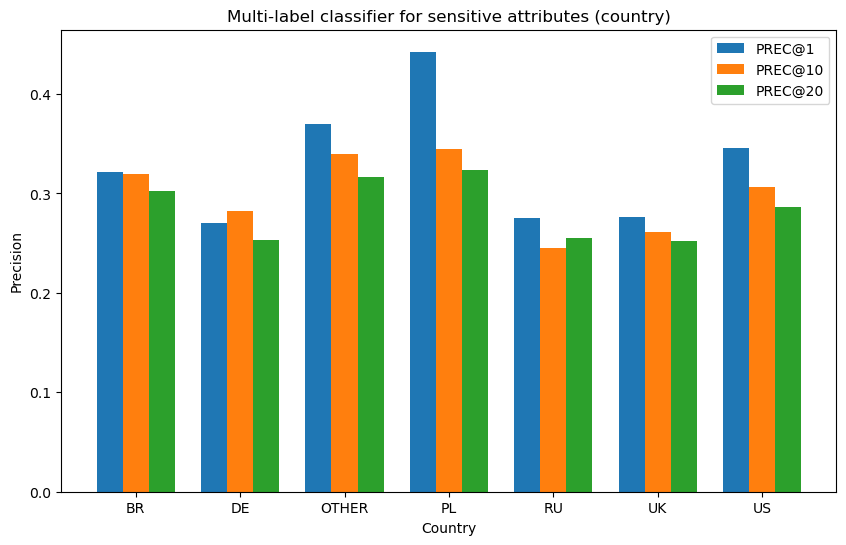

In [24]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
bar_positions_1 = range(len(grouped_df['country']))
bar_positions_2 = [pos + bar_width for pos in bar_positions_1]
bar_positions_3 = [pos + bar_width for pos in bar_positions_2]

# Plotting the bars
ax.bar(bar_positions_1, grouped_df['PREC@1'], width=bar_width, label='PREC@1')
ax.bar(bar_positions_2, grouped_df['PREC@10'], width=bar_width, label='PREC@10')
ax.bar(bar_positions_3, grouped_df['PREC@20'], width=bar_width, label='PREC@20')

# Adding labels and title
ax.set_xlabel('Country')
ax.set_ylabel('Precision')
ax.set_xticks([pos + bar_width for pos in bar_positions_1])
ax.set_xticklabels(grouped_df['country'])
ax.legend()
ax.set_title('Multi-label classifier for sensitive attributes (country)')

# Show the plot
plt.show()

In [18]:
mean_precision_scores = grouped_df[['PREC@1', 'PREC@10', 'PREC@20']].mean()

In [12]:
mean_precision_scores

PREC@1     0.328846
PREC@10    0.299957
PREC@20    0.284218
dtype: float64

In [19]:
mean_precision_scores

PREC@1     0.329212
PREC@10    0.293437
PREC@20    0.272923
dtype: float64